## Initialization

In [1]:
import ase
import os
import sys
import numpy as np
import pandas as pd
from ase.visualize import view
import plotly.express as px
from plotly.offline import init_notebook_mode, plot
init_notebook_mode(connected=True)
from ase.io import read
from dscribe.descriptors.soap import SOAP
from sklearn.preprocessing import normalize
import numpy as np
from openTSNE import TSNE

%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
from pymatgen.core.surface import generate_all_slabs, get_symmetrically_distinct_miller_indices, get_symmetrically_equivalent_miller_indices
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.core import Structure
from pymatgen.io.ase import AseAtomsAdaptor
from itertools import combinations

### Function definitions

In [3]:
def get_surface_sites(slab, height=2.5, only_species=None):
    af=AdsorbateSiteFinder(slab)
    surf_sites = af.find_surface_sites_by_height(
        slab,
        2.5,
    )
    if only_species:
        surf_sites = [
            s for s in surf_sites if s.species_string in only_species
        ]
    surf_index = [i for i in range(len(slab)) if slab.sites[i] in surf_sites]
    return surf_index


#     new_sp = slab.site_properties
#     new_sp['surface_properties'] = surf_props
#     print('surface atoms:{}'.format(surf_props.count('surface')))
#     slab = slab.copy(site_properties=new_sp)
def list2tuple(a):
    if a:
        b = (a[0], a[1], a[2])
    else:
        b = (1, 0, 0)
    return b


def rattle(slab):
    aseslab = AseAtomsAdaptor.get_atoms(slab)
    positions = aseslab.positions
    positions = positions + 0.05 * (2 * np.random.rand(len(positions), 3) - 1)
    aseslab.positions = positions
    frac_coord = aseslab.get_scaled_positions()
    new_slab = slab.copy()
    for i in range(len(new_slab)):
        new_slab[i] = slab[i].species_string, frac_coord[i]
    return new_slab

In [41]:
import scipy.spatial as spatial, scipy.cluster.hierarchy as hc
import seaborn as sns
import logging
import matplotlib
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

# dist = k2d(Kmat)


class clustermap_plot():
    """Author: Sandip De """
    def __init__(self, dist, envdf, linkage_method='complete'):

        self.tdf = pd.DataFrame(
            dist,
            columns=envdf['center'].values,
            index=envdf['center'].values,
        )
        self.linkage = hc.linkage(  #https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage
            spatial.distance.squareform(dist),
            method=linkage_method
        )  #https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.squareform.html#scipy.spatial.distance.squareform
        self.envdf = envdf

    def plot(
        self,
        heatmap_palette='plasma',
        col_palette='Reds',
        row_palette='Blues',
        centers=None,
        envfrac=None,
    ):

        envdf = self.envdf
        tdf = self.tdf
        linkage = self.linkage

        if not centers: centers = list(envdf.center.unique())
        if not envfrac: envfrac = centers

        max_count = envdf[envfrac].values.max()
        min_count = 0

        cmap = ListedColormap(sns.color_palette(col_palette, 256))

        norm = plt.Normalize(0, max_count)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])

        col_colors = pd.DataFrame({}, columns=envfrac)

        for sp in envfrac:
            labels = envdf[sp].values
            labels = (labels / max_count)
            col_colors[sp] = pd.DataFrame(labels)[0].map(cmap)
        col_colors.index = tdf.index

        center_map = {c: i for (c, i) in zip(centers, range(len(centers)))}

        cmap = ListedColormap(sns.color_palette(row_palette, 256))

        row_colors = pd.DataFrame({}, columns=centers)

        for sp in centers:

            labels = envdf['center'].apply(lambda x: 1.0
                                           if x == sp else 0).values
            #             labels = (labels - np.min(labels)) / (np.max(labels) - np.min(labels))
            row_colors[sp] = pd.DataFrame(labels)[0].map(cmap)


#         row_colors = pd.DataFrame(row_colors)
        row_colors.index = tdf.index

        g = sns.clustermap(
            tdf,
            row_linkage=linkage,
            col_linkage=linkage,
            row_cluster=True,
            col_cluster=True,
            col_colors=col_colors,
            row_colors=row_colors,
            yticklabels=100,
            #                ylabel='test',
            xticklabels=100,
            figsize=(10, 10),
            cbar_pos=(1.1, .2, .03, .4),
            cmap=heatmap_palette)

        # g.fig.suptitle('Figure Title \n \n ')
        g.ax_heatmap.set_xlabel('Surface Atom Local Environments')
        g.ax_heatmap.set_ylabel('Surface Atoms Local Environment')
        g.ax_col_dendrogram.set_title(
            'Clustering of {} Surface Atom Environments Based on SOAP Descriptors'
            .format(len(tdf)),
            fontsize=15)
        #         g.ax_col_dendrogram.set_ylabel('fractions')
        g.fig.text(
            1.02,
            0.76,
            'Number of atoms\nin the environment',
            wrap=True,
            horizontalalignment='left',
            #             fontsize=15
        )

        g.fig.text(
            0.1,
            -0.01,
            'Environment Centers',
            wrap=True,
            horizontalalignment='left',
            #             fontsize=15
        )

        divider = make_axes_locatable(g.ax_cbar)

        cax = divider.append_axes(
            'right',
            size='100%',
            pad=0.5,
        )
        cax.set_ylabel('number of atoms')
        g.fig.colorbar(sm, cax=cax, orientation='vertical')
        return g

## Data Generation 

### Start from Bulk structure
We read in a bulk crystal structure for MnIn2O4 from Materials project (mp-35162) as our starting structure.

In [52]:
bulk = Structure.from_file('./surface_analysis_data/Mn2In4O8_mp-35162.cif')
bulk=SpacegroupAnalyzer(bulk).get_conventional_standard_structure()
view(AseAtomsAdaptor.get_atoms(bulk)*[1,1,1],viewer='ngl')

### Generate some slabs
We utilize pymatgen functions to generate symmetrically distinct possible slabs upto miller index of 2 and make sure to get a resoanble surfaece area by repeating the unitcells as required to get x and y cell lengths at least 8 A.

In [77]:
%%time
slabs=generate_all_slabs(bulk,min_slab_size=10,min_vacuum_size=10,max_index=2,)
for i in range(len(slabs)):
    slab=slabs[i]
    scale=[1,1,1]
    if slab.lattice.a <6:
        scale[0]=int(np.ceil(6.0/slab.lattice.a))
    if slab.lattice.b<7:
        scale[1]=int(np.ceil(7.0/slab.lattice.b))
#     print(scale)
    slabs[i].make_supercell(scale)

CPU times: user 39.4 s, sys: 21.8 s, total: 1min 1s
Wall time: 20.7 s


In [79]:
print (f"Generated {len(slabs)} slabs")

Generated 12 slabs


### Modify few surface atoms
Next we identify Indium atoms on the surface and replace two of them by Aluminum atoms by all possible ways. We also rattle the atoms to break the symmetry just to highlight the power of this analysis approach which does not rely on symmetry.

In [65]:
view(AseAtomsAdaptor.get_atoms(slabs[0]))

In [80]:
%%time
tslabs=[]
for slab in slabs:
    
    surf_sites=get_surface_sites(slab,height=2.5,only_species=['In'])
    
    for (site1,site2) in combinations(surf_sites,2):
        
        new_slab=slab.copy()
        new_slab[site1]='Al'
        new_slab[site2]='Al'
        
        
        new_slab=rattle(new_slab) #rattle the atoms to break symmetry
 
        tslabs.append(new_slab)
print (f"Generated {len(tslabs)} slabs")

Generated 146 slabs
CPU times: user 3.23 s, sys: 1.62 s, total: 4.85 s
Wall time: 1.93 s


In [81]:
view(AseAtomsAdaptor.get_atoms(tslabs[10])*[1,1,1],viewer='ngl')

### Save data

In [135]:
from joblib import dump
dump(tslabs,'./surface_analysis_data/surface_models.job')

['./surface_analysis_data/surface_models.job']

## Analysis 
In this section we will not analyse the models that we have created in the previous section. you can just load the models if you have not gone through the previous section. The plan is to analyse local environments of the surface atoms only. The motivation for doing this could be because we want to understand different surface morphologies across different terminations. As an action item one could be interested in understanding possible Oxygen vacancy defects and want to look into main group of Oxygen atoms for which vacancy formation energy calculations should be prioritized. 

In [136]:
from joblib import load
tslabs=load('./surface_analysis_data/surface_models.job')

### Create descriptors 
We are going to use SOAP descriptors for our purpose here. The following code will identify the surface atoms upto depth of 4.5 A from top layer and create SOAP descriptors for all the atoms that satisfy this selection criteria. As additional information for us to understand how the descriptors capture certain simple aspects (eg number of certian atoms in the local environment) we also extract these informations which will be used to validate the observations.  


In [84]:
%%time
from dscribe.descriptors import SOAP
from tqdm import tnrange, tqdm_notebook, notebook
from sklearn.preprocessing import normalize
from scipy.spatial.distance import pdist,squareform

surface_site_list = []
all_slabs_ase = []
all_env_data = []
rcut = 4.5
center_sp_list=['O','In','Mn','Al']
with notebook.tnrange(len(tslabs)) as pbar:

    for slab in tslabs:
        
        
        all_slabs_ase.append(AseAtomsAdaptor.get_atoms(slab))

        surface_sites=get_surface_sites(slab,height=4.5,only_species=center_sp_list)
        
        surface_site_list.append(surface_sites)

        for isite in surface_sites:

            envdata = {}

            envdata['center'] = slab[isite].specie.symbol

            nn = slab.get_neighbors(slab[isite], rcut)

            nn.append(slab[isite])

            s = Structure.from_sites(nn)

            envdata['structure'] = s.as_dict()

            env = [a.specie.symbol for a in nn]

            for sp in np.unique(env):
                envdata[sp] = env.count(sp)

            envdata['miller_index'] = list2tuple(slab.miller_index)
            all_env_data.append(envdata)

        pbar.update(1)

envdf = pd.DataFrame(all_env_data)

species = ['In', 'O','Mn','Al']
rcut = rcut
nmax = 9
lmax = 9

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=True,
    rcut=rcut,
    sigma=0.7,
    sparse=False,
    nmax=nmax,
    lmax=lmax,dtype='float64'

)

soapdesc = soap.create(all_slabs_ase, positions=surface_site_list, n_jobs=10)
tdesc = []
for i in range(len(all_slabs_ase)):
    d = soapdesc[i]
    for j in range(len(d)):
        tdesc.append(d[j])
tdesc=np.array(tdesc)
soapdesc = normalize(tdesc, axis=1) # normalize 

  0%|          | 0/146 [00:00<?, ?it/s]

CPU times: user 30.3 s, sys: 13.6 s, total: 43.9 s
Wall time: 29.9 s


In [85]:
np.shape(soapdesc)

(3118, 6660)

### Dimensionality Reduction
We start by attempting to reduce dimensionality of the descriptor space 

#### PCA

CPU times: user 5.73 s, sys: 2.4 s, total: 8.12 s
Wall time: 2.22 s


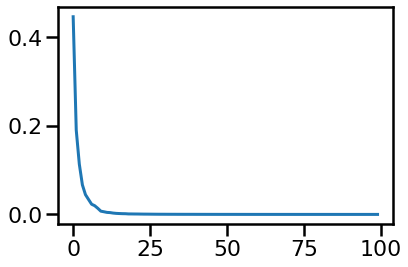

In [86]:
%%time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca=PCA(n_components=100)
pca.fit(soapdesc)
plt.plot(pca.explained_variance_ratio_)

We make a conservative choice of keeping the number of component upto `explained_variance_ratio > 0.001`

In [87]:
n_comp=np.max(np.where(pca.explained_variance_ratio_>0.001)[0])
n_comp

19

In [89]:
soapdesc_pca=pca.transform(soapdesc)[:,0:n_comp]
np.shape(soapdesc_pca)

(3118, 19)

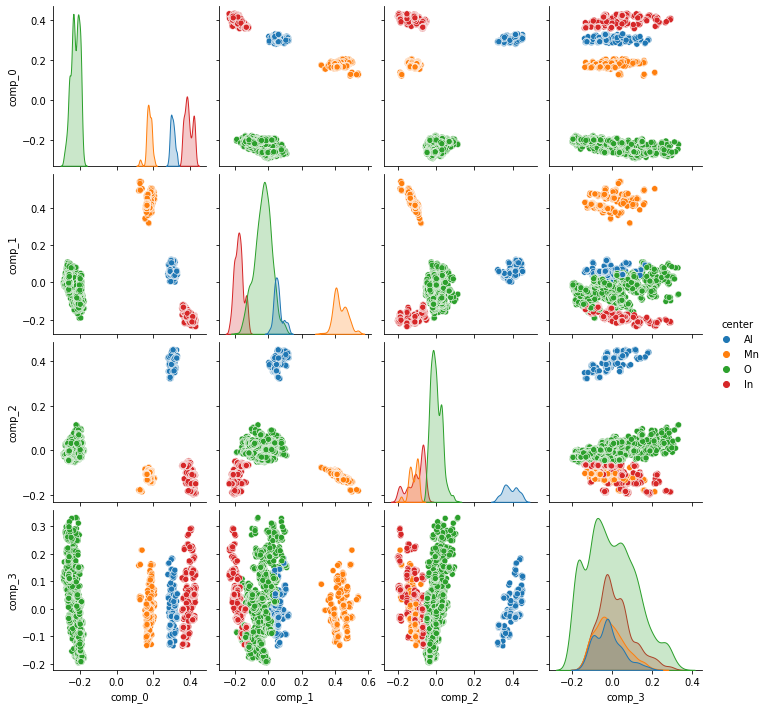

In [95]:
import seaborn as sns 
sns.reset_orig()
descdf=pd.DataFrame({'comp_{}'.format(i): soapdesc_pca[:,i] for i in range(len(soapdesc_pca[0]))})
descdf['center']=envdf.center.values
sns.pairplot(descdf[[*descdf.columns[0:4],'center']],hue='center')

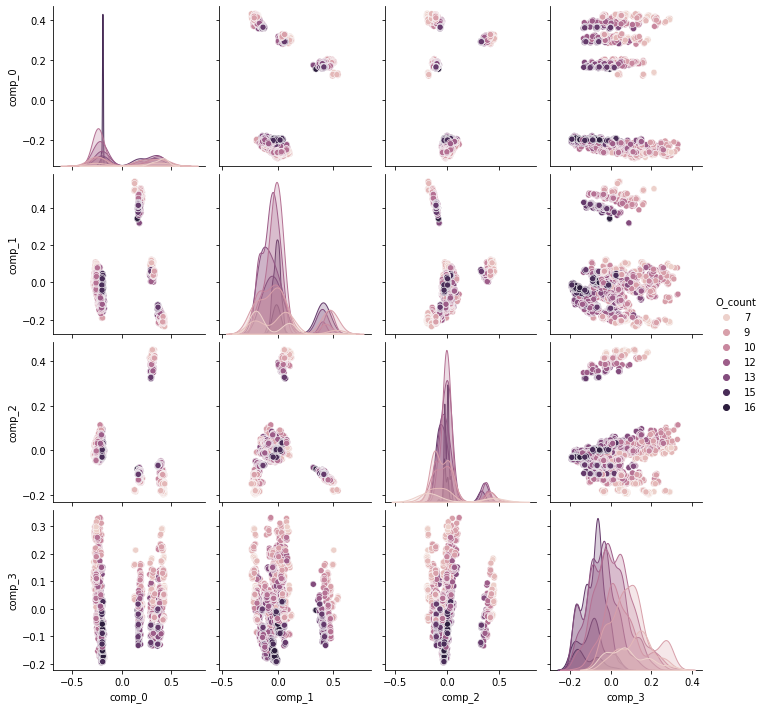

In [96]:
descdf=pd.DataFrame({'comp_{}'.format(i): soapdesc_pca[:,i] for i in range(len(soapdesc_pca[0]))})
descdf['O_count']=envdf.O.values
sns.pairplot(descdf[[*descdf.columns[0:4],'O_count']],hue='O_count')

#### TSNE

In [97]:
from openTSNE import TSNE
tsne = TSNE(
    n_components=2,
    perplexity=200,
    metric="euclidean",
    n_jobs=40, #lower the number if next step crashes
    random_state=42,
    verbose=True,
)


In [93]:
%%time
embedding=tsne.fit(soapdesc_pca)

--------------------------------------------------------------------------------
TSNE(n_jobs=40, perplexity=200, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 600 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 1.86 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.46 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.01 seconds
===> Running optimization with exaggeration=12.00, lr=259.83 for 250 iterations...
Iteration   50, KL divergence 1.9224, 50 iterations in 0.7776 sec
Iteration  100, KL divergence 1.7321, 50 iterations in 0.7600 sec
Iteration  150, KL divergence 1.6978, 50 iterations in 0.6044 sec
Iteration  200, KL divergence 1.6810, 50 iterations in 0.7529 sec
Iteration  250, KL divergence 1.6703, 50 iterations in 0.6382 sec
   --> Time elapsed: 3.53 seconds
===> Running optimization with exaggeration=1.00, l

/gpfs/backup/users/home/desa/venv/edelweiss0.1/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:>

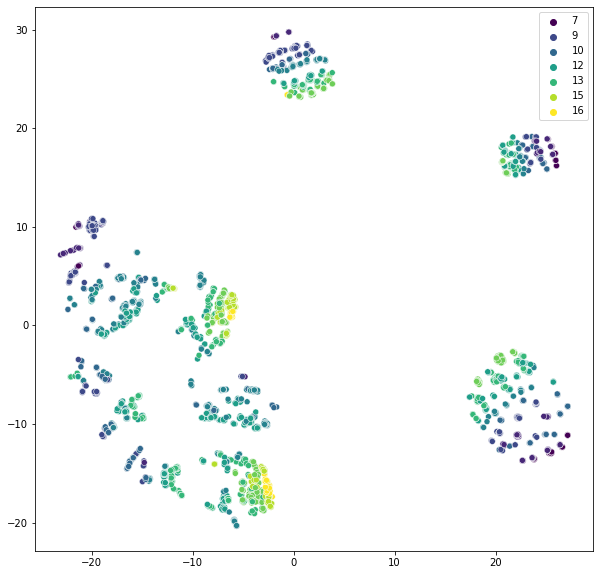

In [98]:
plt.figure(figsize=(10,10))
sns.scatterplot(embedding[:,0],embedding[:,1],hue=envdf.O.values,palette='viridis')

/gpfs/backup/users/home/desa/venv/edelweiss0.1/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:>

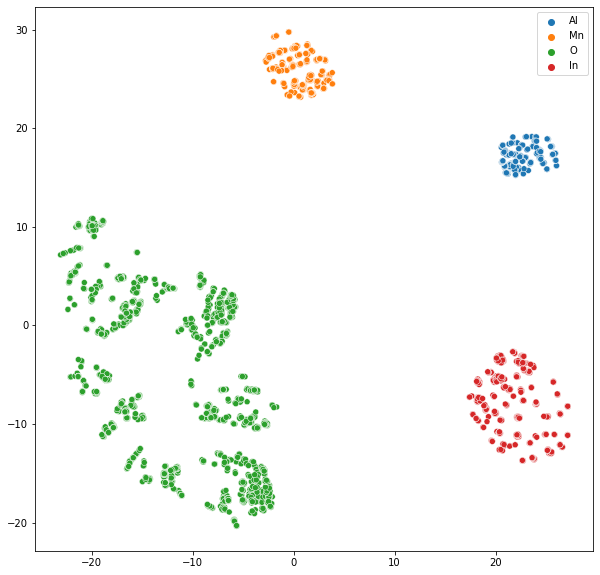

In [99]:
plt.figure(figsize=(10,10))
sns.scatterplot(embedding[:,0],embedding[:,1],hue=envdf.center.values)

### Clustering

Before jumping in to clustering algorithms, let's first create the distance matrix and visualize it. We are using euclidean distance here.

#### Hierarchical Clustering 

We are using a convenient utility class defined before for this purpose here. Feel free to change the linkage_method to any of the following: `ward`,`single`,`average`,`median`,`centroid` to explore the impact of the choices. In the book we have explained what these choices mean. 

CPU times: user 11.5 s, sys: 1.82 s, total: 13.3 s
Wall time: 12.6 s


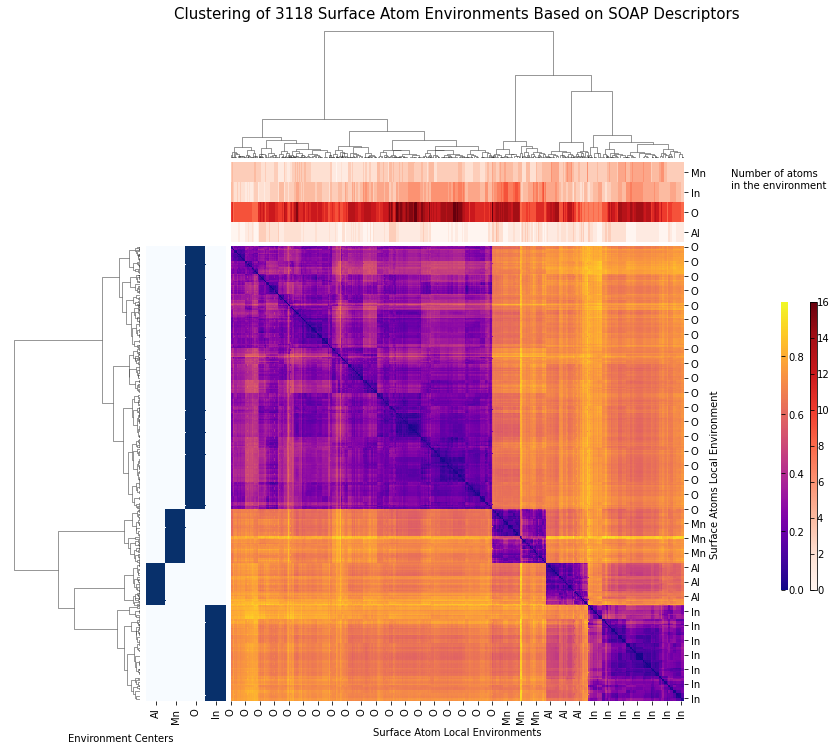

In [100]:
%%time
sns.reset_orig()
dist = squareform(pdist(soapdesc_pca))
clmap = clustermap_plot(dist, envdf=envdf.fillna(0), linkage_method='ward')
clmap.plot(envfrac=['Mn', 'In', 'O', 'Al'])

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline

sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}


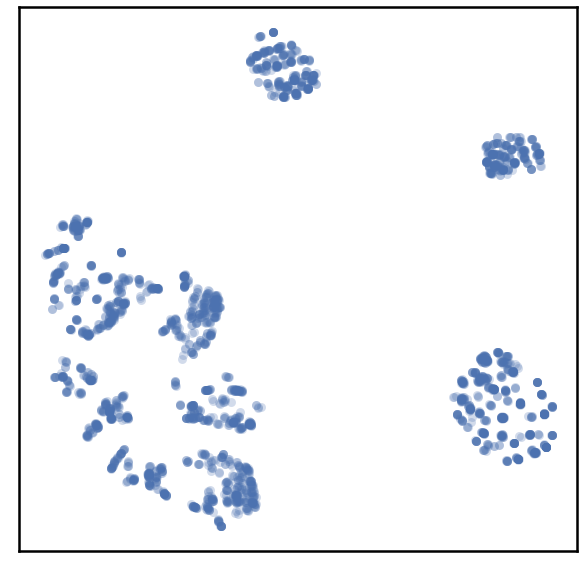

In [102]:
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0], embedding[:,1], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

#### Comparing  Clustering Approaches

In [103]:
def plot_clusters(descriptors, algorithm, args, kwds,map_data=[],ref_labels=[]):
    
    # code to quickly compare different clustering algorithms
    
    start_time = time.time()
    plt.figure(figsize=(10,10))
    labels = algorithm(*args, **kwds).fit_predict(descriptors)
    nclusters=len(np.unique(labels))
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    if len(map_data)==0: map_data=descriptors[:,0:2]
        
    plt.scatter(map_data[:,0], map_data[:,1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('{} Clusters found by {}'.format(nclusters,str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)
    return labels

We do the KMeans clustering on 19 dimensional PCA reduced SOAP descriptors and plot the first two PC colored with the detected clusters

##### KMEANS

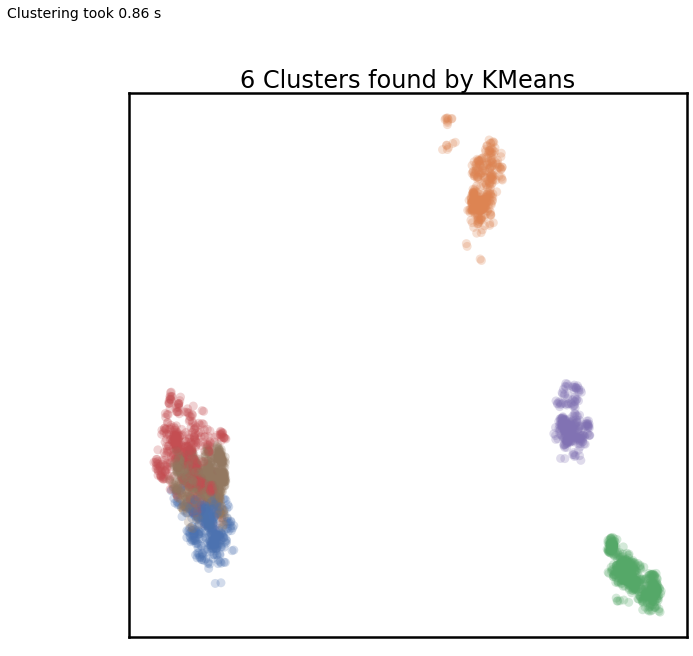

In [134]:
labels=plot_clusters(soapdesc_pca, cluster.KMeans, (), {'n_clusters':6},map_data=[])

We do the same again but this time we pass the tsne embedding for plotting. Now the separation of different clusters are much clear as you see. This clearly demonstrate the advantages of non-liners dimensionality reductions for visual representations.

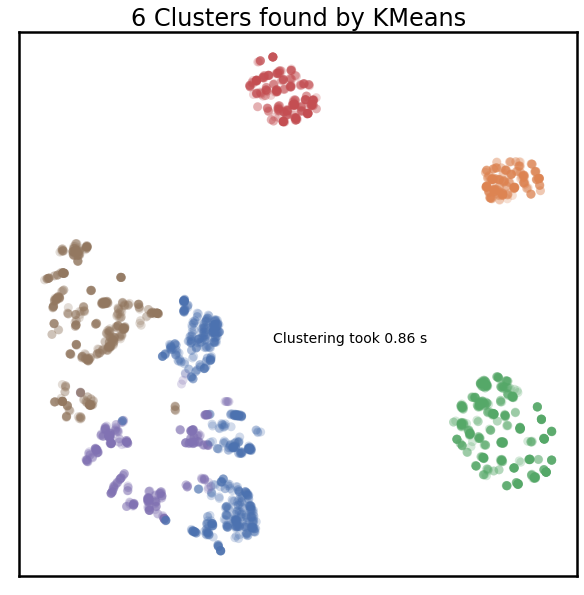

In [133]:
labels=plot_clusters(soapdesc_pca, cluster.KMeans, (), {'n_clusters':6},map_data=embedding)

##### MeanShift

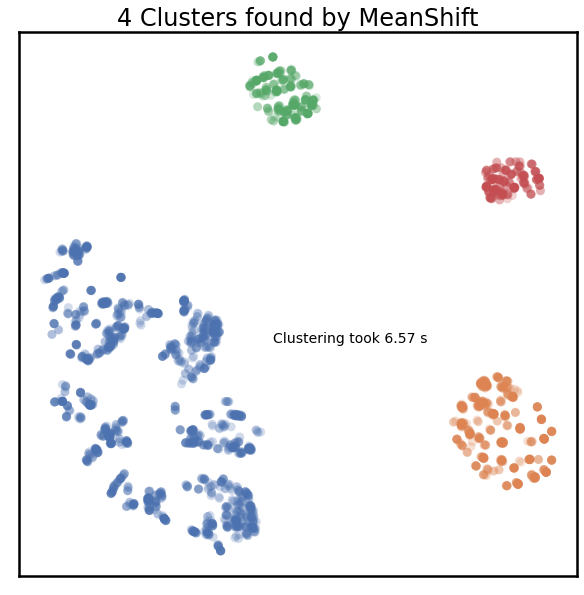

In [115]:
labels=plot_clusters(soapdesc_pca, cluster.MeanShift, (), {'cluster_all':True},map_data=embedding)

##### evaluating clustering results 

In [120]:
from sklearn.metrics import adjusted_mutual_info_score,adjusted_rand_score
ref_labels= envdf.center.values
adjusted_rand_score(ref_labels,labels)

1.0

In [119]:
adjusted_mutual_info_score(ref_labels,labels)

1.0

##### Agglomerative Clustering

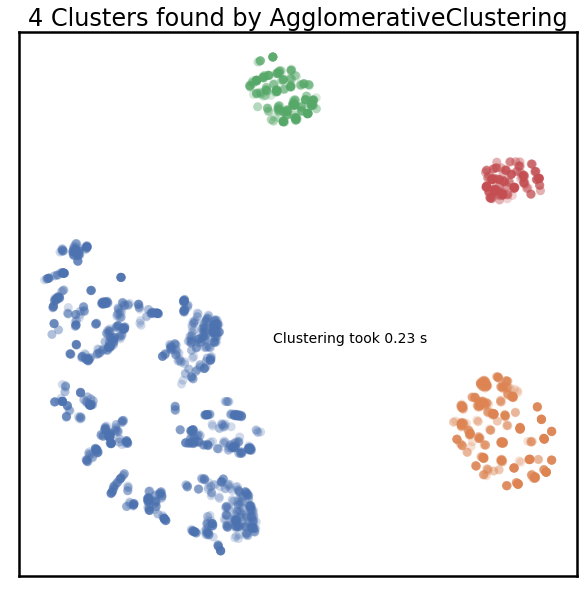

In [122]:
labels=plot_clusters(soapdesc_pca, cluster.AgglomerativeClustering, (), {'n_clusters':4},map_data=embedding)

##### DBSCAN

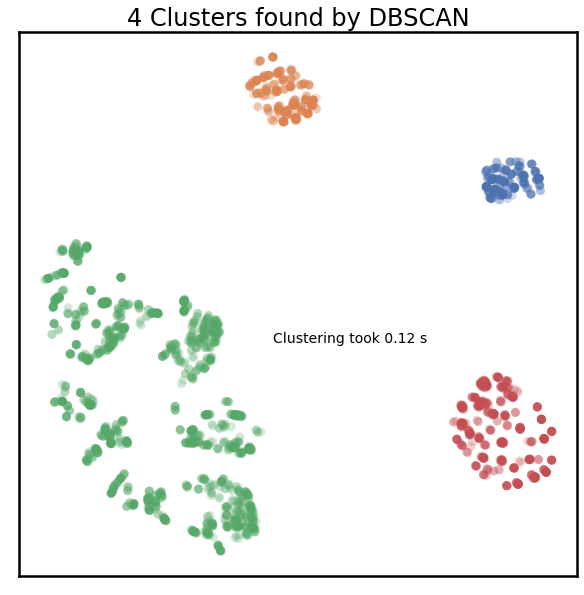

In [124]:
labels=plot_clusters(soapdesc_pca, cluster.DBSCAN, (), {'eps':0.38},map_data=embedding)

##### HDBSCAN

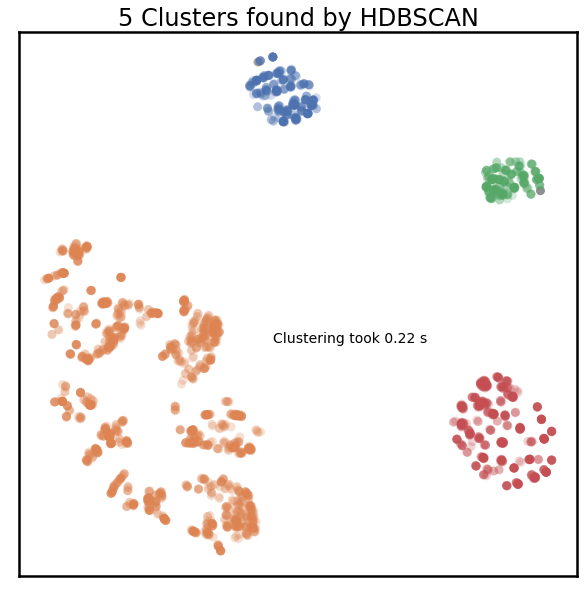

In [126]:
import hdbscan
labels=plot_clusters(soapdesc_pca, hdbscan.HDBSCAN, (), {'min_cluster_size':200},map_data=embedding)